In [1]:
from utils.head import ensemble
from utils.dataset import load_compiled_data
from utils.training import train_aux, train_de
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torchinfo
import time
import os

device = torch.device('cuda:0')

offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]

trajectory_threshold = [800, 700]

train_data = load_compiled_data(ts=[2,3,4], ws=[1], rs=[
                                1, 2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
test_data = load_compiled_data(ts=[2,3,4], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
model_list = [['l_s', 'l_m', 'l_l'], ['m_s', 'm_m', 'm_l'], ['s_s', 's_m', 's_l']]

In [2]:
for ms in model_list:
    model_type = ms[0]
    model = ensemble(f'models/config/model_{model_type}.yaml', device=device)
    
    t0 = time.time()
    #aux
    optimizers = None
    input_reg_training_log = None
    model.input_regs, model.aux_head, epoch, optimizers, input_reg_training_log = train_aux(
        input_regs=model.input_regs,
        aux_head=model.aux_head,
        train_data=train_data,
        test_data=test_data,
        training_log=input_reg_training_log,
        optimizers_algortihm= 'Adam',
        total_epochs=1000,
        lr=1e-4)
    model.epochs['aux'] += epoch
    model.input_regs, model.aux_head, epoch, optimizers, input_reg_training_log = train_aux(
        input_regs=model.input_regs,
        aux_head=model.aux_head,
        train_data=train_data,
        test_data=test_data,
        training_log=input_reg_training_log,
        optimizers_algortihm= 'Adam',
        total_epochs=5000,
        lr=1e-5)
    model.epochs['aux'] += epoch
    model.input_regs, model.aux_head, epoch, optimizers, input_reg_training_log = train_aux(
        input_regs=model.input_regs,
        aux_head=model.aux_head,
        train_data=train_data,
        test_data=test_data,
        training_log=input_reg_training_log,
        optimizers_algortihm= 'Adam',
        total_epochs=35000,
        lr=1e-6)
    model.epochs['aux'] += epoch
    model.input_regs, model.aux_head, epoch, optimizers, input_reg_training_log = train_aux(
        input_regs=model.input_regs,
        aux_head=model.aux_head,
        train_data=train_data,
        test_data=test_data,
        training_log=input_reg_training_log,
        optimizers_algortihm= 'SGD',
        total_epochs=5000,
        lr=1e-6)
    model.epochs['aux'] += epoch
    model.training_log['aux'] = input_reg_training_log
    
    total_time = time.time() - t0
    
    for model_type in ms:
        
        training_dict = {'model_type': model_type,
                         'num_camera': 2,
                         'epochs': model.epochs,
                         'training_log': model.training_log,
                         'state_dict': {'input_reg': model.input_regs.state_dict(),
                                        'de': model.sequential_de.state_dict(),
                                        'aux': model.aux_head.state_dict()},
                          'training_time': total_time}
        torch.save(training_dict, f'models/head/new/{model_type}.pt')

 90%|########9 | 4493/5000 [00:08<00:00, 801.09it/s]

Epoch 4500
Training Modes: 0

Loss:
    Train:
        Cam 1 : 5.2033577958354726e-05
        Cam 2 : 4.141611861996353e-05
    Test:
        Cam 1 : 6.648564885836095e-05
        Cam 2 : 5.033116030972451e-05

MAPE
    Train:
        Cam 1 : 0.23%
        Cam 2 : 0.21%
    Test:
        Cam 1 : 0.30%
        Cam 2 : 0.23%


In [22]:
model = None

In [23]:
for ms in model_list:
    for i in range(0, 3):
    
        torch.manual_seed(0)
        random.seed(0)

        model_type = ms[i]

        if os.path.exists(f'models/head/new/{model_type}.pt'):
            model = ensemble(f'models/config/model_{model_type}.yaml', model_state_dict=f'models/head/new/{model_type}.pt', parts_to_load = ['aux','input_reg'], device=device)
        #else:
            #model = ensemble(f'models/config/model_{model_type}.yaml', device=device)
            
        t0 = time.time()

        #de
        optimizers = None
        de_training_log = None
        model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
            input_regs=model.input_regs, 
            sequential_de=model.sequential_de, 
            train_data=train_data, 
            test_data=test_data, 
            optimizers=optimizers, 
            training_log=de_training_log, 
            mode='random', 
            optimizers_algortihm='Adam',
            total_epochs=100,
            lr=1e-4)
        model.epochs['de'] += epoch
        model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
            input_regs=model.input_regs, 
            sequential_de=model.sequential_de, 
            train_data=train_data, 
            test_data=test_data, 
            optimizers=optimizers, 
            training_log=de_training_log, 
            mode='random', 
            total_epochs=1000,
            lr=1e-5)
        model.epochs['de'] += epoch
        model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
            input_regs=model.input_regs, 
            sequential_de=model.sequential_de, 
            train_data=train_data, 
            test_data=test_data, 
            optimizers=optimizers, 
            training_log=de_training_log, 
            mode='random', 
            optimizers_algortihm='SGD',
            total_epochs=1000,
            lr=1e-6)
        model.epochs['de'] += epoch
        model.training_log['de'] = de_training_log

        total_time = time.time() - t0 + torch.load(f'models/head/new/{model_type}.pt')['training_time']

        training_dict = {'model_type': model_type,
                     'num_camera': 2,
                     'epochs': model.epochs,
                     'training_log': model.training_log,
                     'state_dict': {'input_reg': model.input_regs.state_dict(),
                                    'de': model.sequential_de.state_dict(),
                                    'aux': model.aux_head.state_dict()},
                      'training_time': total_time}
        torch.save(training_dict, f'models/head/new/{model_type}.pt')

100%|#########9| 995/1000 [17:32<00:05,  1.14s/it]

Epoch 995

Drop Choice 1

Loss:
    Train:
        Current : 4.9134054279420525e-05
        
    Test:
        Deep    : 3.608842598623596e-05
        Shallow : 5.835006959387101e-05

MAPE 
    Train:
        Current : 0.20%
    Test:
        Deep    : 0.20%
        Shallow : 0.25%
    Test (Max):
        Deep    : 0.10 nm
        Shallow : 0.15 nm


In [2]:
for model_type in ['m_m', 'm_l', 'l_s', 'l_l']:
    model = ensemble(f'models/config/model_{model_type}.yaml', model_state_dict=f'models/head/new/{model_type}.pt', device=device)
    de_training_log = model.training_log['de']
    optimizers = None
    t0 = time.time()
    model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
                input_regs=model.input_regs, 
                sequential_de=model.sequential_de, 
                train_data=train_data, 
                test_data=test_data, 
                optimizers=optimizers, 
                training_log=de_training_log, 
                mode='random', 
                optimizers_algortihm='SGD',
                total_epochs=10000,
                lr=1e-6)
    total_time = time.time() - t0
    total_time += torch.load(f'models/head/new/{model_type}.pt')['training_time']

    model.epochs['de'] += epoch
    model.training_log['de'] = de_training_log

    training_dict = {'model_type': model_type,
                         'num_camera': 2,
                         'epochs': model.epochs,
                         'training_log': model.training_log,
                         'state_dict': {'input_reg': model.input_regs.state_dict(),
                                        'de': model.sequential_de.state_dict(),
                                        'aux': model.aux_head.state_dict()},
                          'training_time': total_time}
    torch.save(training_dict, f'models/head/new/{model_type}.pt')

 56%|#####5    | 5570/10000 [2:06:36<1:37:34,  1.32s/it]

Epoch 5570

Drop Choice 2

Loss:
    Train:
        Current : 5.968203822703799e-06
        
    Test:
        Deep    : 1.7433500033803284e-05
        Shallow : 5.120277273817919e-05

MAPE 
    Train:
        Current : 0.15%
    Test:
        Deep    : 0.13%
        Shallow : 0.25%
    Test (Max):
        Deep    : 0.09 nm
        Shallow : 0.21 nm


In [6]:
training_dict = {'model_type': model_type,
                     'num_camera': 2,
                     'epochs': model.epochs,
                     'training_log': model.training_log,
                     'state_dict': {'input_reg': model.input_regs.state_dict(),
                                    'de': model.sequential_de.state_dict(),
                                    'aux': model.aux_head.state_dict()},
                      'training_time': total_time}
torch.save(training_dict, f'models/head/new/{model_type}.pt')

In [5]:
model.eval_data(train_data, test_data)

MODEL EVALUATION

Trained Epochs : 
    Aux : 46000
    De  : 7675

Input Regularization
Loss:
    Train:
        Cam 1 : 2.7808275717688957e-06
        Cam 2 : 2.4544262942072237e-06
    Test:
        Cam 1 : 3.2509276479686378e-06
        Cam 2 : 3.3773344512155745e-06

MAPE
    Train:
        Cam 1 : 0.13%
        Cam 2 : 0.13%
    Test:
        Cam 1 : 0.18%
        Cam 2 : 0.16%
    
Distance Estimator
Loss:
    Train:
        Current : 1.83763262384673e-07

    Test:
        Deep    : 1.743303073453717e-06
        Shallow : 5.119993147673085e-06

MAPE 
    Train:
        Current : 0.12%
    Test:
        Deep    : 0.13%
        Shallow : 0.25%
    Test (Max):
        Deep    : 0.01 nm
        Shallow : 0.02 nm


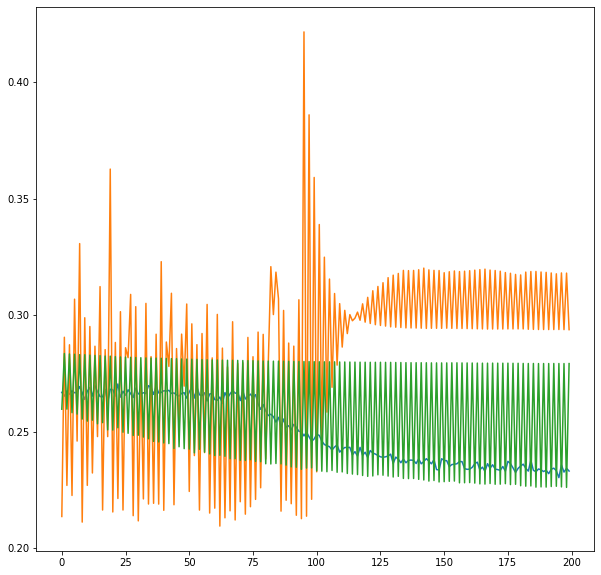

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.plot(de_training_log[0][-200:]/16905)
plt.plot(de_training_log[1].reshape(2,-1)[0][-200:])
plt.plot(de_training_log[1].reshape(2,-1)[1][-200:])

In [33]:
training_dict = {'model_type': model_type,
                     'num_camera': 2,
                     'epochs': model.epochs,
                     'training_log': model.training_log,
                     'state_dict': {'input_reg': model.input_regs.state_dict(),
                                    'de': model.sequential_de.state_dict(),
                                    'aux': model.aux_head.state_dict()},
                      'training_time': total_time}
torch.save(training_dict, f'models/head/new/{model_type}.pt')